In [1]:

### General imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import pandas as pd


from emukit.test_functions import forrester_function
from emukit.core.loop.user_function import UserFunctionWrapper
from emukit.core import ContinuousParameter, ParameterSpace
from pyDOE import lhs

import GPy
from emukit.model_wrappers.gpy_model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement
from emukit.core.optimization import GradientAcquisitionOptimizer
from GPy.models import GPRegression



In [2]:

LEGEND_SIZE = 15
target_function, space = forrester_function()


# In[17]:


x_plot = np.linspace(space.parameters[0].min, space.parameters[0].max, 200)[:, None]
y_plot = target_function(x_plot)

list_point = np.array( [x_plot,y_plot])
index = np.argmin(list_point[1])   
x_min = list_point[0][index]  
y_min = target_function(x_min)#找到最小值点

X_all = x_plot
Y_all = y_plot
# x_shift = -0.5

# x_new_1 = [[0.758 + x_shift]]

In [13]:
df = pd.DataFrame()

n_loop = 1        #循环求均值次数，也即整个流程循环次数
maxiter = 15        #模型迭代次数
num_x_init = 3

for _ in range(n_loop):
    tol = 1


    simple_regret = []

    X_init = lhs(len(space.parameters), num_x_init, criterion='maximin')

#     X_init = np.append(X_init, x_new_1, axis=0)
    # X_init = np.array(np.random.rand(2,1))
    Y_init = target_function(X_init)

#     gpy_model = GPy.models.GPRegression(X_init, Y_init, GPy.kern.RBF(1, lengthscale=0.08, variance=20), noise_var=1e-10)
#     emukit_model = GPyModelWrapper(gpy_model)
    
    input_dim = 1

    ker = GPy.kern.Matern52(input_dim = input_dim, ARD = True)#

    # ker.lengthscale.constrain_bounded(0.01, 5) #lengthscale决定着点与点之间的相互作用程度
    # ker.variance.constrain_bounded(1e-2, 10000.0) #方差

    model_gpy = GPRegression(X_init,Y_init, ker)

    # model_gpy.Gaussian_noise.variance =0.25
    # model_gpy.Gaussian_noise.variance.fix()

    model_gpy.randomize()
    model_gpy.optimize_restarts(num_restarts=10,verbose =False, messages=False)

    emukit_model = GPyModelWrapper(model_gpy)

    X = X_init
    Y = Y_init

    for i in range(maxiter):
        emukit_model.set_data(X, Y)
        # nlcb_acquisition = NegativeLowerConfidenceBound(emukit_model)
        #
        # optimizer = GradientAcquisitionOptimizer(space)
        # x_new, _ = optimizer.optimize(nlcb_acquisition)

        ei_acquisition = NegativeLowerConfidenceBound(emukit_model)
        
        ei_plot = ei_acquisition.evaluate(X_all)
        ei_acquisition_nom = (ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot))
        
        
#         optimizer = GradientAcquisitionOptimizer(space)
#         x_new, _ = optimizer.optimize(ei_acquisition)
#         y_new = target_function(x_new)

        # 遍历 X 中的每一行
        for x_row in X:
            # 找到 x_row 在 X_all 中的位置索引
            indices = np.where(np.all(X_all == x_row, axis=1))[0]

            # 将对应位置上的 ei_plot 元素设置为 0
            ei_acquisition_nom[indices] = 0

        bs = 1
        sort_index = np.argsort(ei_acquisition_nom, axis =0)

        x_new = []
        top = 1 # You should set it according to your confidence in the model (balance of exploitation and exploration)
        for i in sort_index[-top:]:
                x_new.append(X_all[i][0])


        x_new=np.array(x_new)
        y_new = target_function(x_new)


        X = np.append(X, x_new, axis=0)
        Y = np.append(Y, y_new, axis=0)

        regret = abs(min(Y) - y_min).item()
        simple_regret.append(regret)


    # 将 simple_regret 列表转换为 DataFrame
    df_temp = pd.DataFrame([simple_regret])

    # 将 DataFrame 追加到主 DataFrame 中
    df = pd.concat([df, df_temp], ignore_index=True)

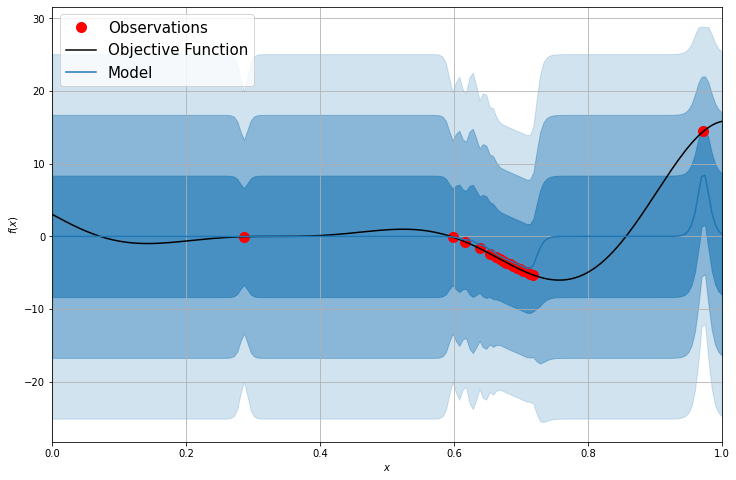

In [14]:

emukit_model.set_data(X, Y)

mu_plot, var_plot = emukit_model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(emukit_model.X, emukit_model.Y, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)
plt.show()



In [ ]:
    
# 导出 DataFrame 到 Excel 表格
df.to_excel('simple_regret_bo.xlsx', index=False, header=False)